# TP 03 : Régression logistique Binaire 


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

## 1- Implémentation 

In [2]:
# Des données pour tester les fonctions
# Testes unitaires
X_t = np.array([[2., -8.], [1., -2.], [1., 2.]])
Y_t = np.array([0., 1., 1.])
Theta_t = np.array([0.5, 0.25])

### 1.1- Fonctions utiles

In [3]:
# une fonction qui normalise une matrice sur chaque colonne 
# dans l'entrainnement, on calcule les moyennes et les déviations de chaque colonne
# dans le teste, on ne doit pas recalculer ces deux paramètres. 
# Mais, on doit utiliser ceux calculés dans l'entrainnement
def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std

#Résultat : 
#(array([[ 1.41421356, -1.29777137],
#        [-0.70710678,  0.16222142],
#        [-0.70710678,  1.13554995]]),
# array([ 1.33333333, -2.66666667]),
# array([0.47140452, 4.10960934]))
normaliser(X_t), normaliser(X_t, 1, 4)

((array([[ 1.41421356, -1.29777137],
         [-0.70710678,  0.16222142],
         [-0.70710678,  1.13554995]]),
  array([ 1.33333333, -2.66666667]),
  array([0.47140452, 4.10960934])),
 (array([[ 0.25, -2.25],
         [ 0.  , -0.75],
         [ 0.  ,  0.25]]), 1, 4))

In [4]:
# Préparer la matrice des caractéristiques pour l'entrainnement ou la prédiction
# On applique la normalisation sur chaque colonne (sauf si : norm=False)
# Ensuite on ajoute une colonne des 1 (sauf si : const=False)
def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std
#Résulat : 

preparer(X_t), preparer(X_t, norm=False), preparer(X_t, const=False)

((array([[ 1.        ,  1.41421356, -1.29777137],
         [ 1.        , -0.70710678,  0.16222142],
         [ 1.        , -0.70710678,  1.13554995]]),
  array([ 1.33333333, -2.66666667]),
  array([0.47140452, 4.10960934])),
 (array([[ 1.,  2., -8.],
         [ 1.,  1., -2.],
         [ 1.,  1.,  2.]]), None, None),
 (array([[ 1.41421356, -1.29777137],
         [-0.70710678,  0.16222142],
         [-0.70710678,  1.13554995]]),
  array([ 1.33333333, -2.66666667]),
  array([0.47140452, 4.10960934])))

In [5]:
# Défininir des fonctions qui génèrent des vecteurs ou des matrices
# Ces fonctions seront utilisées pour générer les Thétas

def generer_zeros_1(nbr):
    return np.zeros(nbr)

def generer_uns_1(nbr):
    return np.ones(nbr)

def generer_aleatoire_1(nbr):
    return np.random.rand(nbr)
    
generer_zeros_1(2), generer_uns_1(2), generer_aleatoire_1(2)

(array([0., 0.]), array([1., 1.]), array([0.97657062, 0.69803368]))

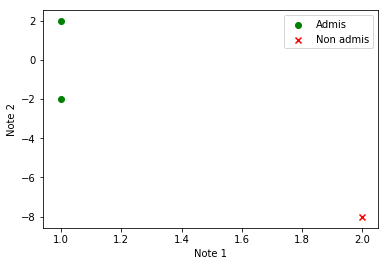

In [6]:
def afficher_2(X, Y, L=None, Y_labels=["Admis", "Non admis"], X_labels=["Note 1", "Note 2"]):
    oui = Y == 1
    plt.scatter(X[oui, 0], X[oui, 1], color="green", marker="o", label=Y_labels[0])
    plt.scatter(X[~oui, 0], X[~oui, 1], color="red", marker="x", label=Y_labels[1])
    if L is not None:
        x_values, y_values = L
        plt.plot(x_values, y_values, label="ligne de decision")
    plt.xlabel(X_labels[0])
    plt.ylabel(X_labels[1])
    plt.legend()
    plt.show()
afficher_2(X_t,Y_t)

In [7]:
# th0 + th1 * x1 + th2 * x2 = 0
def ligne_decision(X, Theta):
    X1 = [np.min(X[:,0]), np.max(X[:,0])]
    X2 = np.max(X[:,1])
    X2_min = X2 - (Theta[0] + Theta[1] * X1[0]) / Theta[2]
    X2_max = X2 - (Theta[0] + Theta[1] * X1[1]) / Theta[2]
    return X1, [X2_min, X2_max]

### 1.2- Combinaison linéaire
On combine les m caractéristiques linéairement

$$z=\theta_0+\sum\limits_{i=1}^{m} \theta_i x_i = \theta^T X$$

In [8]:
# TODO la fonction qui calcule la combination linéaire entre les caractéristiques
# Vous l'avez déjà vu dans la régression linéaire
def z_1(X, Theta): 
   return np.dot(X,Theta.T)

#Résulat : array([-0.5,  0. ,  1.5])

z_1(X_t, Theta_t)

array([-1.,  0.,  1.])

### 1.2- Calcul de probabilité
La valeur combinée est transformée à une probabilité en utilisant la fonction logistique 

$$\sigma(z)=\frac{1}{1 + e^{-z}}$$

In [9]:
# TODO La fonction ségmoid
# Elle doit fonctionner sur des scalaires ou des vecteurs de numpy
def sigmoid(X):
    return 1/(1+np.exp(-1*X))

# résultat: (0.5, array([0.26894142, 0.73105858]))
sigmoid(0), sigmoid(np.array([-1, 1]))

(0.5, array([0.26894142, 0.73105858]))

In [10]:
def h_1(X, Theta, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return sigmoid(z_1(X_pre, Theta))

# Résultat : array([0.26894142, 0.5       , 0.73105858])
h_1(X_t, Theta_t)

array([0.26894142, 0.5       , 0.73105858])

### 1.3- La fonction du cout 

$$ cout(h_\theta(x), y) = \begin{cases}
- \log(h_\theta(x)) & \text{ si } y = 1\\ 
- \log(1 - h_\theta(x))  & \text{ si } y = 0
\end{cases}$$

Puisque $ y \in \{0, 1\}$ donc, 

$$ cout(h_\theta(x), y) = - y \log(h_\theta(x)) - (1-y) \log(1 - h_\theta(x))$$

$$J(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m} cout(h_\theta(x^{(i)}), y^{(i)})$$

In [11]:
# TODO : La fonction de cout utilisée dans la régression logistique 
# H est la prédiction 
# Y est la valeur réel
def J_1(H, Y): 
    m = X_t.shape[0]
    cout_total = -(1 / m) * np.sum(Y* np.log(H) + (1 - Y) * np.log(1 - H))
    return cout_total

# Résultat : 0.4398901851987969
J_1(h_1(X_t, Theta_t), Y_t)

0.4398901851987969

### 1.4- Les gradients

$$\frac{\partial J(\theta)}{\theta_j} = \frac{1}{m} \sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_{ij} $$

In [12]:
# TODO: Définir la fonction de gradient :
def gradient_1(X, H, Y):
    m = X.shape[0] 
    return (1 / m) * np.dot(X.T, (H) - Y)
   

# Résultat : array([-0.07701953, -0.56313807])
gradient_1(X_t, h_1(X_t, Theta_t), Y_t)

array([-0.07701953, -0.56313807])

### 1.5- Entraînnement (algorithme du gradient)

Les coéfficients sont mis à jour itérativement en se basant sur le gradient et un pas d'apprentissage $\alpha$. Puisque cette fonction a été implémentée dans le TP précédent, elle est donnée ici, mais d'une façon plus parametrable.

$$\theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\theta_j} $$

Notre fonction d'entrainnement prend les paramètres suivantes : 
- X : matrice (échantillons X caractéristiques)
- Y : vecteur (ou matrice) des résultas (échantillons X nombre_classes)
- norm : si on normalise X ou nom (par défaut : True)
- const : si on ajoute $\theta_0$ ou non (par défaut : True)
- nbr_iter : nombre des itérations avant de sortir
- alpha : le pas d'apparentissage (Learning rate)
- eps : le test d'arrêt si la différence entre les couts (actuel et précédent) est inférieur à $\epsilon$ on arrête la désente même si on n'a pas terminé toutes les itérations
- theta_func : la fonction qui génère les $\theta$ (par défaut : zéros)
- h_func : la fonction qui calcule les probabilités (par défaut : h_1)
- J_func : la fonction du cout (par défaut : J_1)
- grad_func : la fonction qui calcule le gradient (par défaut : gradient_1)

In [13]:
# Puisque c'était fait en premier TP, la fonction est donnée 
# Ce n'ai pas la peine de modifier
def entrainer_1(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_1, h_func=h_1, J_func=J_1, grad_func=gradient_1): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = theta_func(X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts

theta1, mean1, std1, couts1 = entrainer_1(X_t, Y_t)

# Résultat : 
#(array([ 1.98675108, -3.42409929,  2.41978457]),
#array([ 1.33333333, -2.66666667]),
#array([0.47140452, 4.10960934]),
#0.003838026695967539)
theta1, mean1, std1, couts1[-1]

(array([ 1.98675108, -3.42409929,  2.41978457]),
 array([ 1.33333333, -2.66666667]),
 array([0.47140452, 4.10960934]),
 0.003838026695967539)

### 1.6- Prédiction 

Etant donnée un seuil et des probabilités, pour chaque probabilité on rend 1 si elle dépasse ou égale le seuil, 0 sinon. 

In [14]:
# TODO compléter cette fonction 
# H est un vecteur de probabilités 
def predire_1(H, seuil=0.5): 
    return np.array([int(item >= seuil) for item in H])

    

# Résultat : array([0, 1, 1])
predire_1(h_1(X_t, Theta_t))

array([0., 1., 1.])

### 1.7- Regrouper les fonctions ensemble 

Pour bien gérer l'entrainnement et la prédiction, on rassemble les fonctions que vous avez implémenté dans une seul classe. L'intérêt : 
- Si on applique la normalisation durant l'entrainnement, on doit l'appliquer aussi durant la prédiction. En plus, on doit utiliser les mêmes paramètres (moyenne et écart-type)
- On utilise les thétas optimales lors de la prédicition


In [15]:
# ne modifier pas ici
class RegLogistique(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_1, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        self.Theta, self.mean, self.std, self.couts = entrainer_1(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_1(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_1(H, seuil=seuil)

reg_lin = RegLogistique(const=False)
reg_lin.entrainer(X_t, Y_t)
reg_lin.predire(np.array([[2., -2.],[-1., 1.]]))

array([0.00205785, 0.99794215])

## 2- Application sur un exemple simple 

**Cette partie est juste pour tester votre code sur un petit exemple (pas de questions à complir)**

Nous avons générer une dataset avec deux notes sur 20. Si la moyenne est supérieure ou égale à 10 la classe est "admis" (1), sinon (0)

Si vous êtes intéressé par le code utilisé pour générer cette dataset, consulter (datasets/notes_generation.py)

In [16]:
notes = pd.read_csv("datasets/notes.csv")
notes.head()

,Note1,Note2,Admis
0,9.75,16.00,1
1,2.25,9.50,0
2,4.50,2.50,0
3,15.50,10.25,1
4,3.25,19.50,1


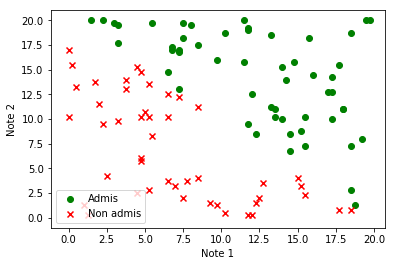

In [17]:
# Extraction des features 
X_notes = notes.iloc[:, :-1].values # Premières colonnes 

Y_notes = notes.iloc[:,-1].values # Dernière colonne 

afficher_2(X_notes, Y_notes)

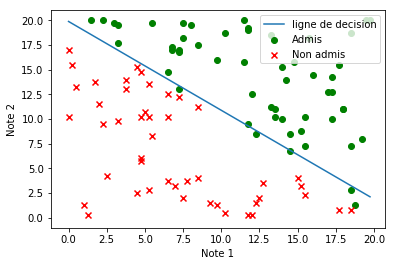

In [18]:
reg_notes = RegLogistique()
reg_notes.entrainer(X_notes, Y_notes)

line_decision = ligne_decision(X_notes, reg_notes.Theta)

afficher_2(X_notes, Y_notes, L=line_decision)

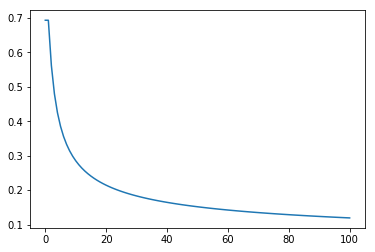

In [19]:
plt.plot(reg_notes.couts)

## 3- Exécution sur un exemple réel

On veut aider les médecins à bien décider si les patients contaminés par COVID-19 doivent être hospitalisés ou traités à leurs maisons. Dans ce cas, on veut estimer si un malade va guérir ou non. 

Pour ce faire, on va utiliser [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset). Pour des fins de simplicité, on se contante par les caractéristiques : le pays et l'age. 

### 3.1- Lecture de dataset

In [20]:

corona = pd.read_csv("datasets/COVID19_line_list_data.csv")
corona.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
corona.shape[0]

1085

### 3.2- Préparation de dataset

On veut préparer la dataset afin qu'elle soit adéquate à notre problème (prédire si un malade va rétablir ou non)

**Pour bien répondre à cette section, utiliser pandas. Consulter le premier TP (Préparation de données)**

In [22]:
corona["recovered"].unique()
# On remarque que la caractéristique "recovered" a plusieurs valeurs possibles
# Ici 0 veut dire le patient n'est pas rétabli 
# 1 veut dire le patient est rétabli
# Les autres valeurs sont des dates et elles veulent dire que le partient est rétabli

# La caractéristique "death" a le même sens des valeurs, mais en remplaçant "rétabli" par "mort"

array(['0', '1', '02/12/20', '1/15/2020', '12/30/1899', '02/08/20',
       '2/14/2020', '02/04/20', '2/18/2020', '02/05/20', '2/17/2020',
       '02/09/20', '2/15/2020', '2/27/2020', '2/19/2020', '2/20/2020',
       '1/17/2020', '02/07/20', '2/21/2020', '2/23/2020', '02/11/20',
       '2/22/2020', '2/16/2020', '2/24/2020', '2/26/2020', '2/25/2020',
       '02/06/20', '2/28/2020', '1/30/2020', '2/13/2020', '02/02/20',
       '1/31/2020'], dtype=object)

In [23]:
# TODO on veut garder seulement les échantillons où les patients sont rétablis (recovered) ou morts (death)
corona = corona.loc[(corona["recovered"]!="0")|(corona["death"]!="0")]
# Résultat : 222
corona.shape[0]


222

In [24]:
# TODO on veut garder garder seulement les caractéristiques "country", "age" et "recovered"
# Astuce : voir DataFrame.filter
corona = corona.filter(items=["country","age","recovered"])
corona.head()

,country,age,recovered
48,China,61.0,0
49,China,69.0,0
50,China,89.0,0
51,China,89.0,0
52,China,66.0,0


In [25]:
# on veut que les valeurs de "recovered" soient 1 ou 0
corona["recovered"] = corona["recovered"].map(lambda x: 0 if x == "0" else 1)

corona.isnull().sum()

country       0
age          19
recovered     0
dtype: int64

In [26]:
# TODO filtrer les échantillons avec des valeurs (gender et age) nulles
corona = corona[corona.age.notnull()]
corona.info()

# Les trois colonnes doivent avoir 203 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 48 to 993
Data columns (total 3 columns):
country      203 non-null object
age          203 non-null float64
recovered    203 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.3+ KB


In [27]:
# On veut garder seulement les 3 premiers pays en question de nombre
corona["country"].value_counts()

Singapore      59
China          42
South Korea    28
Malaysia       19
Japan          17
Vietnam         8
France          4
Hong Kong       4
Australia       4
UAE             4
USA             3
Thailand        3
Phillipines     2
Canada          2
Nepal           1
Sri Lanka       1
Taiwan          1
UK              1
Name: country, dtype: int64

In [28]:
msk = corona["country"].isin(["Singapore", "China", "South Korea"])
corona = corona.loc[msk]
corona["country"].value_counts()

Singapore      59
China          42
South Korea    28
Name: country, dtype: int64

In [29]:
# Extraction des caractéristiques 
X_corona = corona.iloc[:, :-1].values # Premières colonnes 

Y_corona = corona.iloc[:,-1].values # Dernière colonne 

X_corona[:3, :]

array([['China', 61.0],
       ['China', 69.0],
       ['China', 89.0]], dtype=object)

### 3.3- Encodage des caractéristiques

La régression s'applique seulement sur des caractéristiques numériques et pas nominales. 
On veut tester l'effet de choisir le bon encodeur. 
Pour ce faire, on va tester avec deux encodeurs : 
- Encodage ordinal : les valeurs d'une caractéristique sont attribuées des nombres selon l'ordre de la première occurence 
- Encodage One Hot : chaque valeur d'une caractéristique devient une colonne avec une valeur de 1 ou 0

In [30]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

X_corona_pays = encoder.fit_transform(X_corona[:, 0].reshape(len(X_corona), 1))

X_corona_ordinal = np.concatenate((X_corona_pays, X_corona[:, 1].reshape((len(X_corona), 1))), axis=1)

X_corona_ordinal[:3, :]

array([[0.0, 61.0],
       [0.0, 69.0],
       [0.0, 89.0]], dtype=object)

In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

X_corona_pays = encoder.fit_transform(X_corona[:, 0].reshape(len(X_corona), 1))

X_corona_onehot = np.concatenate((X_corona_pays, X_corona[:, 1].reshape((len(X_corona), 1))), axis=1)

X_corona_onehot[:10, :]

array([[1.0, 0.0, 0.0, 61.0],
       [1.0, 0.0, 0.0, 69.0],
       [1.0, 0.0, 0.0, 89.0],
       [1.0, 0.0, 0.0, 89.0],
       [1.0, 0.0, 0.0, 66.0],
       [1.0, 0.0, 0.0, 75.0],
       [1.0, 0.0, 0.0, 48.0],
       [1.0, 0.0, 0.0, 82.0],
       [1.0, 0.0, 0.0, 66.0],
       [1.0, 0.0, 0.0, 81.0]], dtype=object)

### 3.4- Entrainnement 

In [32]:
# Randomization des données pour marquer les 80% lignes
msk = np.random.rand(len(X_corona)) < 0.8 

Y_corona_train = np.array(Y_corona[msk], dtype=np.float32)
Y_corona_test = np.array(Y_corona[~msk], dtype=np.float32)

X_corona_ordinal_train = np.array(X_corona_ordinal[msk, :], dtype=np.float32)
X_corona_ordinal_test = np.array(X_corona_ordinal[~msk, :], dtype=np.float32)

X_corona_onehot_train = np.array(X_corona_onehot[msk, :], dtype=np.float32)
X_corona_onehot_test = np.array(X_corona_onehot[~msk, :], dtype=np.float32)

Y_corona_test

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0.], dtype=float32)

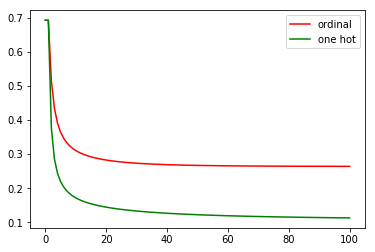

In [33]:
reg_corona_ordinal = RegLogistique()
reg_corona_onehot = RegLogistique()

# TODO compléter le  code afin d'entrainer deux modèles 
reg_corona_ordinal.entrainer(X_corona_ordinal_train, Y_corona_train)
reg_corona_onehot.entrainer(X_corona_onehot_train, Y_corona_train)


#Affichage des évolutions des couts 
plt.plot(reg_corona_ordinal.couts, color="red", label="ordinal")
plt.plot(reg_corona_onehot.couts, color="green", label="one hot")
plt.legend()
plt.show()

**Question** : Que remarquez-vous ? Analysez 

**Réponse** : le taux d'erreur de hot et plus petit par rapport au ordinal


**Analyse** : 


In [34]:
reg_corona_ordinal.Theta, reg_corona_onehot.Theta

(array([ 0.6841213 ,  0.95392455, -2.88806383]),
 array([ 1.22099955, -1.7059062 ,  1.75488764, -0.12729   , -2.5818748 ]))

### 3.5- Test 

On mesure la qualité d'un système de classification en utilisant la matrice de confusion : 

| -  | Estimé (1) | Estimé (0) |
| --- | ---| ---|
| Réel (1) | TP (vrais positifs) | FN (faux négatifs)|
| Réel (0) | TP (faux positifs) | TN (vrais négatifs) |

Il y a deux métriques : 
- la précision (ou valeur prédictive positive) est la proportion des items pertinents parmi l'ensemble des items proposés ; 
- le rappel (ou sensibilité) est la proportion des items pertinents proposés parmi l'ensemble des items pertinents. 


In [35]:
# TODO compléter le test; ici, on veut la prédiction sous forme de 1 et 0 et pas des probabulités
# Le seuil est 0.5 (par défaut)
H_corona_ordinal_test = reg_corona_ordinal.predire(X_corona_ordinal_test, prob=False)
H_corona_onehot_test = reg_corona_onehot.predire(X_corona_onehot_test, prob=False)

# Afficher la somme des 1 pour chaque 
H_corona_ordinal_test.sum(), H_corona_onehot_test.sum()




(14.0, 18.0)

In [36]:
# TODO compléter les fonctions qui calculent la matrice de confusion 
def calculerTP(Y_reel, Y_predit): 
    return (((Y_reel == Y_predit) & (Y_reel == 1 ))+0).sum()

def calculerFN(Y_reel, Y_predit): 
    return (((Y_reel != Y_predit) & (Y_reel == 1 ))+0).sum()

def calculerFP(Y_reel, Y_predit): 
    return (((Y_reel != Y_predit) & (Y_reel != 1 ))+0).sum()

def calculerTN(Y_reel, Y_predit): 
    return (((Y_reel == Y_predit) & (Y_reel != 1 ))+0).sum()

TP_corona_ordinal = calculerTP(Y_corona_test, H_corona_ordinal_test)
FN_corona_ordinal = calculerFN(Y_corona_test, H_corona_ordinal_test)
FP_corona_ordinal = calculerFP(Y_corona_test, H_corona_ordinal_test)
TN_corona_ordinal = calculerTN(Y_corona_test, H_corona_ordinal_test)

TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal

(3, 2, 7, 12)

In [37]:
# Pour vérifier votre solution 
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_corona_test, H_corona_ordinal_test).ravel()
tn, fp, fn, tp

(3, 2, 7, 12)

In [41]:
TP_corona_onehot = calculerTP(Y_corona_test, H_corona_onehot_test)
FN_corona_onehot = calculerFN(Y_corona_test, H_corona_onehot_test)
FP_corona_onehot = calculerFP(Y_corona_test, H_corona_onehot_test)
TN_corona_onehot = calculerTN(Y_corona_test, H_corona_onehot_test)

TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot

(4, 1, 2, 17)

In [42]:
# TODO compléter les fonctions suivantes
def rappel(TN, FP, FN, TP): 
    return TP / (TP + FN)

def precision(TN, FP, FN, TP): 
    return TP / (TP + FP)

In [43]:
# Comparaison du recouvrement 
R_corona_ordianl = rappel(TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal)
R_corona_onehot = rappel(TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot)

R_corona_ordianl, R_corona_onehot

(0.631578947368421, 0.8947368421052632)

**Question** : Que pouvez-vous constater ? 

**Réponse** : par rapport au recouvrement les deux types de codage donnent le même recouvrement
              


In [44]:
# Comparaison de la précision 
P_corona_ordianl = precision(TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal)
P_corona_onehot = precision(TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot)

P_corona_ordianl, P_corona_onehot

(0.8571428571428571, 0.9444444444444444)

**Question** : Que pouvez-vous constater ? 

**Réponse** : la prècision de one-hot encoding est le meilleure  a adaptè que ordinal encoding
